# Estimacion de produccion de Aceite

In [1]:
#triada de la death
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (12,8)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }

plt.style.use('ggplot')

# Modelos
import lightgbm as lgb
from sklearn.cluster import KMeans

# Interpretacion
import shap
from pdpbox import pdp, info_plots

#mis tools
import sys
sys.path.append('../serch_tools/')
import serch_tools as st

In [2]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [3]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [4]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [5]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [6]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [7]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


In [8]:
# # SOLO SE TRABAJA CON 10 ANIOS Y SE QUITA UNA FECHA ATIPICA
# db_prod_mol = db_prod_mol[(db_prod_mol.fecha_produccion > '2003-12-01') & (db_prod_mol.fecha_produccion != '2013-08-01')
#                           & (db_prod_mol.fecha_produccion != '2013-07-01')]

In [9]:
# SOLO SE TRABAJA CON 10 ANIOS Y SE QUITA UNA FECHA ATIPICA
db_prod_mol = db_prod_mol[(db_prod_mol.fecha_produccion > '2004-12-01')
#                           & (db_prod_mol.fecha_produccion != '2013-08-01')
#                           & (db_prod_mol.fecha_produccion != '2013-07-01') & (db_prod_mol.fecha_produccion != '2013-06-01')
                         ]

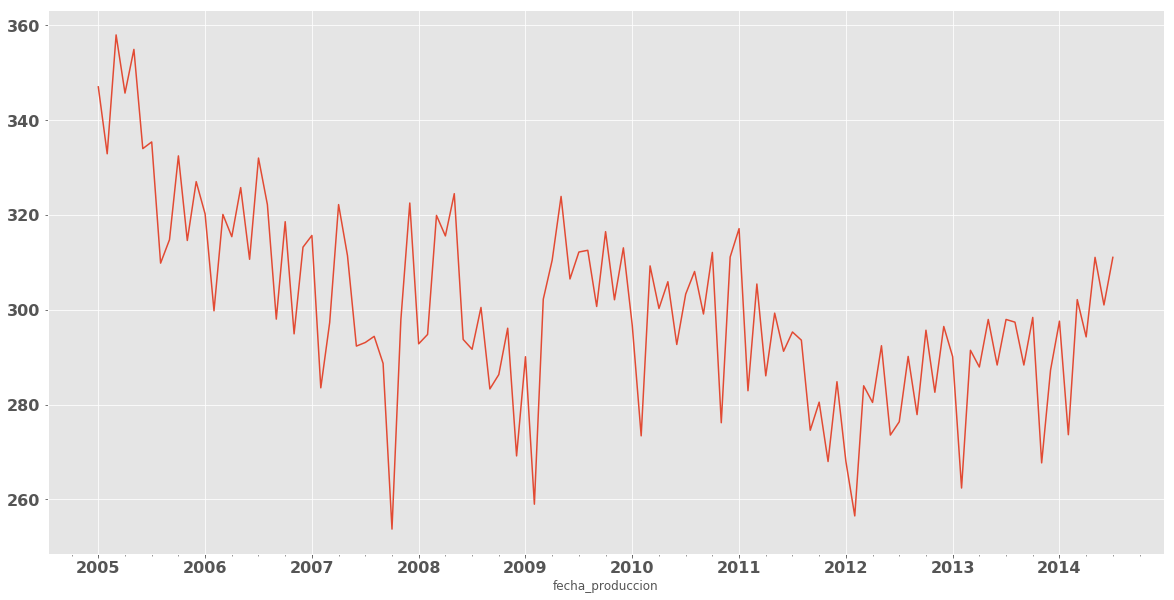

In [10]:
db_prod_mol[
    db_prod_mol.fecha_produccion>='2000-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().plot(figsize=(20,10))

# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [11]:
# tabla (t - 12)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 11)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -10)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 9)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 8)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -7)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t - 6)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

#tabla (t - 5)
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

#tabla (t - 4) 
t_8 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-8)

#tabla (t - 3) 
t_9 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-9)

#tabla (t - 2) 
t_10 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-10)

#tabla (t - 1) 
t_11 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-11)

#tabla (t)  variable a estimar
t_12 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-12)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [12]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12],1).dropna()
df.columns = ['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [13]:
df.shape # numero de registros

(11559, 13)

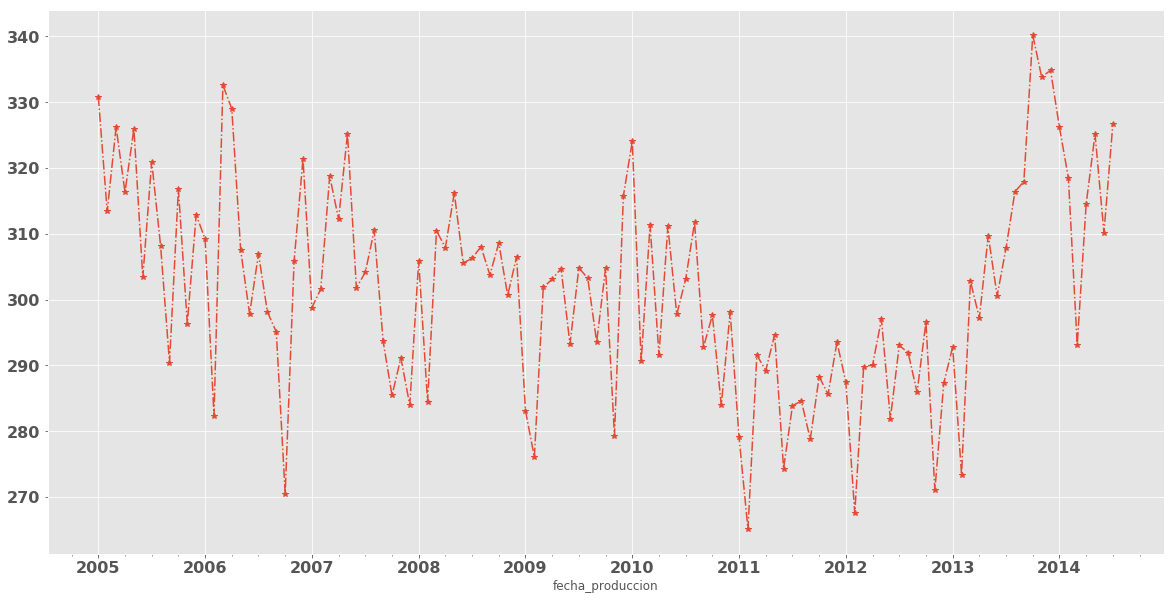

In [14]:
df.groupby('fecha_produccion').Produccion_barriles_t.mean().plot(figsize=(20,10),style='-.', marker='*')

In [15]:
#tabla (t)  fecha real
# fecha_de_y = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-12)

In [16]:
df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

# cambio en la produccion
df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [17]:
df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

# cambio en la produccion
df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1

In [18]:
df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                        'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                        'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)

In [19]:
df.columns

Index(['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
       'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'diff_t_12_t_11', 'diff_t_11_t_10',
       'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'diff_t_2_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8', 'ratio_t_8_t_7',
       'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4', 'ratio_t_4_t_3',
       'ratio_t_3_t_2', 'ratio_t_6_t_1', 'ratio_t_5_t_1', 'ratio_t_

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [20]:
# desviacion estandar
df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                           'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 12 meses

In [21]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [23]:
df['sum_produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)

In [24]:
df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

In [25]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 4*df.std_t_12_t_1 > df.Produccion_barriles_t,1,0)

In [26]:
# df[df.dummi_pico_bajo==1][['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1',
#                            'std_t_6_t_1','media_movil_t_6_t_1']].head()

In [27]:
df[df.dummi_pico_bajo==1].shape

(354, 88)

In [28]:
df = df[df.dummi_pico_bajo!=1]

In [29]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

# variables del modelo de gas

In [30]:
# tabla (t - 12)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t - 11)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

# tabla (t -10)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-2)

# tabla (t - 9)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-3)

# tabla (t - 8)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-4)

# tabla (t -7)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-5)

# tabla (t - 6) 
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-6)

#tabla (t - 5)
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-7)

#tabla (t - 4) 
t_8 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-8)

#tabla (t - 3) 
t_9 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-9)

#tabla (t - 2) 
t_10 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-10)

#tabla (t - 1) 
t_11 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-11)

#tabla (t) 
t_12 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-12)

In [31]:
t_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12],1).dropna()
t_gas.columns = ['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1',
              'Produccion_gasMMpc_t']

In [32]:
df = pd.concat([df,t_gas],1).dropna()

In [33]:
df.shape

(11205, 101)

In [34]:
# desviacion estandar
df['stdgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].std(1)
# mediana
df['mediangas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].median(1)
# minimo
df['mingas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].min(1)
#quantiles
df['q75gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.75,axis=1)
df['q25gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.25,axis=1)
df['q90gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.90,axis=1)
df['q10gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.10,axis=1)
#maximo
df['maxgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].max(1)

#rango
df['rangogas_t12_t1'] = df['maxgas_t_12_t_1'] - df['mingas_t_12_t_1']

In [35]:
# medias moviles
df['media_movilgas_t_2_t_1'] = df[['Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_3_t_1'] = df[['Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_4_t_1'] = df[['Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_5_t_1'] = df[['Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_6_t_1'] = df[['Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

## variable dummie de mes

In [36]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2005-01-01              0        0        0        0        0   
              2005-02-01              0        0        0        0        0   
              2005-03-01              0        0        0        0        0   
              2005-04-01              0        0        0        0        0   
              2005-05-01              0        0        0        0        0   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2005-01-01              0        1        0        0         0   
              2005-02-01              0        0        1        0         0   
              2005-03-01              0        0        0        1         0   
              2005-04-01              0        0        0        0         1   
              2005-05-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2005-01-01               0         0  
              2005-02-01               0         0  
              2005-03-01               0         0  
              2005-04-01               0         0  
              2005-05-01               1         0

In [37]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [38]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [39]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [40]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [41]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [42]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
116,MOLOACAN-111,2005-01-01,206.76,196.45,207.49,137.20,96.35,32.45,302.00,341.82,...,0,0,0,0,0,0,0,1,17.985929,-94.370707
117,MOLOACAN-111,2005-02-01,196.45,207.49,137.20,96.35,32.45,302.00,341.82,343.84,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
118,MOLOACAN-111,2005-03-01,207.49,137.20,96.35,32.45,302.00,341.82,343.84,375.88,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
119,MOLOACAN-111,2005-04-01,137.20,96.35,32.45,302.00,341.82,343.84,375.88,367.63,...,0,0,0,0,0,0,0,0,17.985929,-94.370707
120,MOLOACAN-111,2005-06-01,96.35,32.45,302.00,341.82,343.84,375.88,367.63,402.55,...,0,0,0,0,0,0,0,0,17.985929,-94.370707


In [43]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'latitud', 'longitud'],
      dtype='object', length=132)

# calculo de numero de plataformas cercanas

In [44]:
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [45]:
#Funcion par calcular la distiancia de un punto a otro
import math
from math import sin, cos, sqrt, atan2, radians
def haversine(lon1, lat1, lon2, lat2):
    R = 6373.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [46]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

In [47]:
df_fecha_creacion = db_prod_mol.groupby('Pozo').fecha_produccion.min().reset_index()
df_fecha_creacion.columns = ['Pozo','primera_fecha_produccion']

In [48]:
lat_lon_pozo = lat_lon_pozo.merge(df_fecha_creacion,on='Pozo')
lat_lon_pozo.head()

,Pozo,latitud,longitud,primera_fecha_produccion
0,MOLOACAN-111,17.985929,-94.370707,2005-01-01
1,MOLOACAN-112,17.985046,-94.367871,2005-01-01
2,MOLOACAN-121,17.987249,-94.368291,2005-05-01
3,MOLOACAN-132,17.989190,-94.366750,2006-06-01
4,MOLOACAN-1400,17.960963,-94.382869,2005-01-01


In [49]:
dist = []
# lat_lon = lat_lon_pozo.valuesm PENDIENTE OPTIMIZARLA CON NUMPY ARRAYS
for i in range(lat_lon_pozo.shape[0]):
    for j in range(lat_lon_pozo.shape[0]):
        if i != j and lat_lon_pozo.loc[i,'primera_fecha_produccion'] >= lat_lon_pozo.loc[j,'primera_fecha_produccion']: 
            # se subestimada la construccion para
            # no regarla pero estaria bien pegarle por fecha donde uno se para
            distancia = haversine(lat_lon_pozo.loc[i,'longitud'], lat_lon_pozo.loc[i,'latitud'],
                              lat_lon_pozo.loc[j,'longitud'],lat_lon_pozo.loc[j,'latitud'])
            dist.append([lat_lon_pozo.iloc[i].Pozo,lat_lon_pozo.iloc[j].Pozo,distancia])

In [50]:
df_dist = pd.DataFrame(dist)
df_dist.columns = ['Pozo','pozo2','distancia']
df_dist['es_cercano'] = np.where(df_dist.distancia <= 1,1,0)

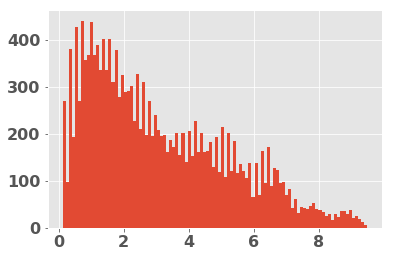

In [51]:
df_dist.distancia.hist(bins=100)

In [52]:
df_num_pozos_cercanos = pd.DataFrame(df_dist.groupby('Pozo').es_cercano.sum()).reset_index()
df_num_pozos_cercanos.columns = ['Pozo','num_pozos_a_menos_de_1km']
df_train = df_train.merge(df_num_pozos_cercanos, how='left',on='Pozo').dropna()

In [53]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud,num_pozos_a_menos_de_1km
0,MOLOACAN-111,2005-01-01,206.76,196.45,207.49,137.20,96.35,32.45,302.00,341.82,...,0,0,0,0,0,0,1,17.985929,-94.370707,10
1,MOLOACAN-111,2005-02-01,196.45,207.49,137.20,96.35,32.45,302.00,341.82,343.84,...,0,0,0,0,0,0,0,17.985929,-94.370707,10
2,MOLOACAN-111,2005-03-01,207.49,137.20,96.35,32.45,302.00,341.82,343.84,375.88,...,0,0,0,0,0,0,0,17.985929,-94.370707,10
3,MOLOACAN-111,2005-04-01,137.20,96.35,32.45,302.00,341.82,343.84,375.88,367.63,...,0,0,0,0,0,0,0,17.985929,-94.370707,10
4,MOLOACAN-111,2005-06-01,96.35,32.45,302.00,341.82,343.84,375.88,367.63,402.55,...,0,0,0,0,0,0,0,17.985929,-94.370707,10


# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [54]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [55]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [56]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [57]:
df_train.shape

(10976, 146)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf


NO VALE LA PENA TODOS LOS POZOS SON DE DESARROLLO O SIN INFORMACION

In [58]:
# clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
#     'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
# clasifi_lahee.reset_index(inplace=True)
# clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
# clasifi_lahee.head()

In [59]:
# df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [60]:
# df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [61]:
# df_train.shape

In [62]:
# df_train.head()

# Saturacion y porosidad 
FALTA BITACORA PARA PEGARLE VARIABLES GEOLOGICAS

# HACE FALTA UNA BITACORA DE COMO FUERON SUBIENDO PARA PODER PEGAR TODA ESTA INFORMACION

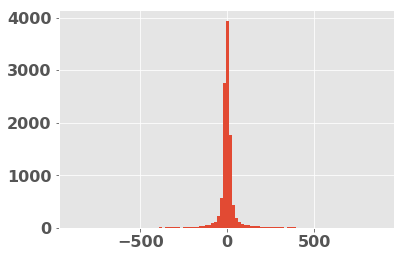

In [63]:
df_train.diff_t_2_t_1.hist(bins=100)

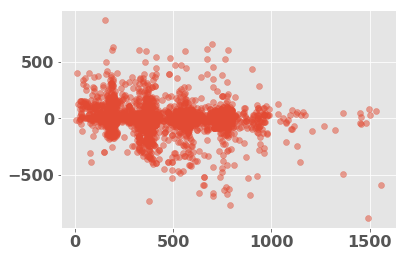

In [64]:
plt.scatter(df_train.Produccion_barriles_t, df_train.diff_t_2_t_1, alpha=0.5)

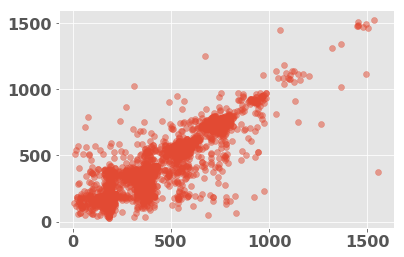

In [65]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_2_t_1, alpha=0.5)

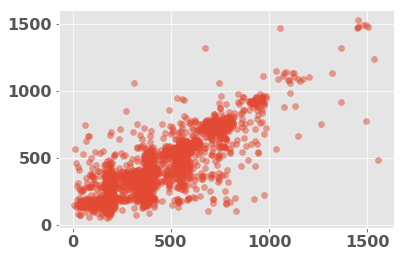

In [66]:
plt.scatter(df_train.Produccion_barriles_t, df_train.media_movil_t_3_t_1, alpha=0.5)

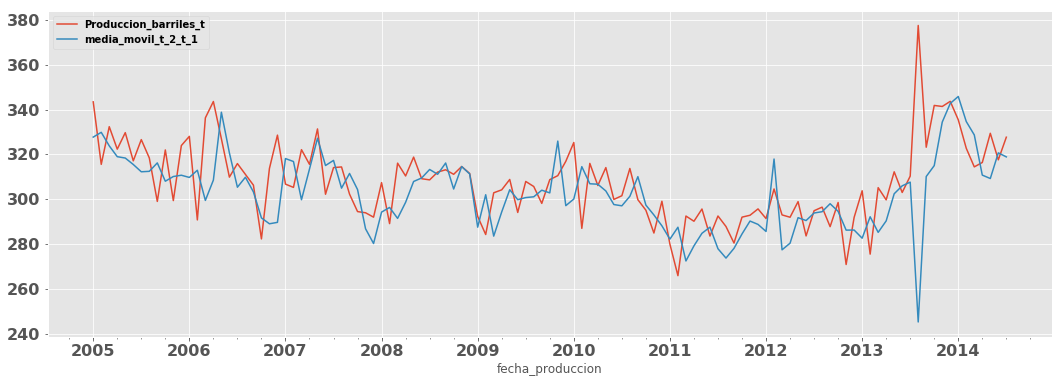

In [67]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','media_movil_t_2_t_1']].mean().plot(figsize=(18,6))

In [68]:
(185.47 + 137.72)/2

161.595

In [69]:
df_train[['media_movil_t_2_t_1','Produccion_barriles_t_2','Produccion_barriles_t_1','Produccion_barriles_t']].head()

,media_movil_t_2_t_1,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t
0,385.09,367.63,402.55,241.71
1,322.13,402.55,241.71,198.81
2,220.26,241.71,198.81,70.53
3,134.67,198.81,70.53,96.25
4,83.39,70.53,96.25,199.31


# pendiente pico historico

In [70]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [71]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [72]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [73]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [74]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [75]:
# db_prod_mol.columns

In [76]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [77]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [78]:
df_train.shape

(10976, 146)

## Quitamos Outliers

In [79]:
np.array(df_train.columns)

array(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'diff_t_12_t_11', 'diff_t_11_t_10', 'diff_t_10_t_9',
       'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',
       'ratio_t_4_t_3', 'ratio_t_3_t_2', 'ratio_t

In [80]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [81]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [82]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [83]:
df_train = df_train[df_train.diff_t_2_t_1 > df_train.diff_t_2_t_1.quantile(0.005)]
df_train = df_train[df_train.diff_t_2_t_1 < df_train.diff_t_2_t_1.quantile(0.99)]

In [84]:
df_train.reset_index(inplace=True, drop=True)

In [85]:
df_train.shape

(9928, 146)

In [86]:
df_train = df_train[df_train.Produccion_gasMMpc_t > df_train.Produccion_gasMMpc_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_gasMMpc_t_1 > df_train.Produccion_gasMMpc_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2> df_train.Produccion_gasMMpc_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3> df_train.Produccion_gasMMpc_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4> df_train.Produccion_gasMMpc_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5> df_train.Produccion_gasMMpc_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6> df_train.Produccion_gasMMpc_t_6.quantile(0.001)]

In [87]:
df_train = df_train[df_train.Produccion_gasMMpc_t < df_train.Produccion_gasMMpc_t.quantile(0.99)]

In [88]:
df_train = df_train[df_train.Produccion_gasMMpc_t_1 < df_train.Produccion_gasMMpc_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2 < df_train.Produccion_gasMMpc_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3 < df_train.Produccion_gasMMpc_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4 < df_train.Produccion_gasMMpc_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5 < df_train.Produccion_gasMMpc_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6 < df_train.Produccion_gasMMpc_t_6.quantile(0.99)]

# Clustering Vemos que hay tipos de pozos con produccion similar

In [89]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,equipo_perforacion_PM-5571,equipo_perforacion_PM-5596,equipo_perforacion_PM-5597,equipo_perforacion_PM-5599,equipo_perforacion_PM-5626,equipo_perforacion_PM-5627,equipo_perforacion_PM-73,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION
0,MOLOACAN-111,2005-01-01,206.76,196.45,207.49,137.20,96.35,32.45,302.00,341.82,...,0,0,0,0,0,0,0,0,0,1
1,MOLOACAN-111,2005-02-01,196.45,207.49,137.20,96.35,32.45,302.00,341.82,343.84,...,0,0,0,0,0,0,0,0,0,1
2,MOLOACAN-111,2005-04-01,137.20,96.35,32.45,302.00,341.82,343.84,375.88,367.63,...,0,0,0,0,0,0,0,0,0,1
3,MOLOACAN-111,2005-06-01,96.35,32.45,302.00,341.82,343.84,375.88,367.63,402.55,...,0,0,0,0,0,0,0,0,0,1
4,MOLOACAN-111,2005-07-01,32.45,302.00,341.82,343.84,375.88,367.63,402.55,241.71,...,0,0,0,0,0,0,0,0,0,1


In [90]:
np.array(df_train.columns)

array(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'diff_t_12_t_11', 'diff_t_11_t_10', 'diff_t_10_t_9',
       'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',
       'ratio_t_4_t_3', 'ratio_t_3_t_2', 'ratio_t

In [91]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','equipo_perforacion_PM-78']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'sum_produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [92]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [93]:
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k, n_jobs=6)
#     km = km.fit(df_std)
#     Sum_of_squared_distances.append(km.inertia_)

In [94]:
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.xticks(np.arange(1,15));

In [95]:
kmeans = KMeans(n_clusters=5, n_jobs=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=6, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [96]:
df_train = pd.concat([df_train, pd.get_dummies(
    kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [97]:
df_train["cluster"] = pd.DataFrame(kmeans.predict(df_std)).dropna()

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [98]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster'],
      dtype='object', length=152)

# AED

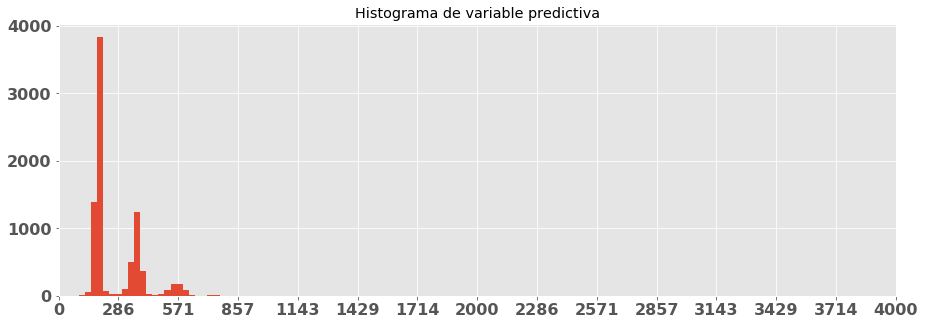

In [99]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [100]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5',
       ...
       'equipo_perforacion_PM-73', 'equipo_perforacion_PM-78',
       'equipo_perforacion_PM-92', 'equipo_perforacion_SIN INFORMACION',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster'],
      dtype='object', length=152)

En algun momento dibujaras un mapa aqui

In [101]:
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'sum_produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [102]:
# for i in num_cols:
#     plt.subplots()
#     sns.regplot(df_train[i],df_train.Produccion_barriles_t)
#     plt.title(i)

In [103]:
# lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
# idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [104]:
df_prod_heatmap = df_train.set_index('fecha_produccion').groupby([
    'Pozo',pd.Grouper(freq='1Y')]).Produccion_barriles_t.sum()

Text(0.5, 1.0, 'Produccion anual por pozo, historia')

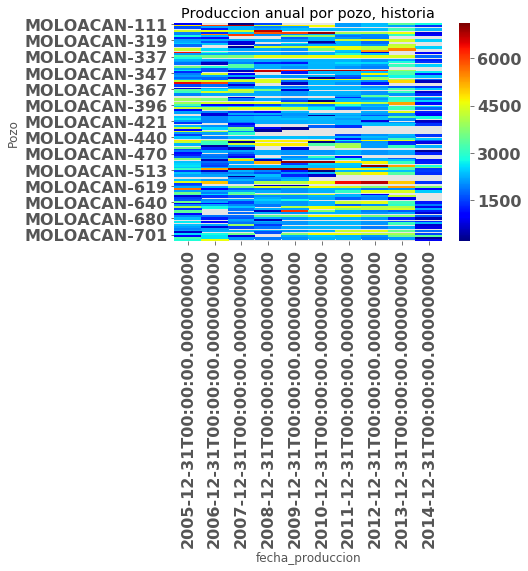

In [105]:
sns.heatmap(df_prod_heatmap.unstack(),cmap='jet')
plt.title('Produccion anual por pozo, historia')

In [106]:
df_prod_heatmap = df_prod_heatmap.reset_index()

In [107]:
# df_prod_heatmap[df_prod_heatmap.fecha_produccion == '1999-12-31'].merge(
#     lat_lon_pozo[['Pozo','latitud','longitud']], on='Pozo').set_index('Pozo').Produccion_barriles_t.sort_values().plot.barh()

# heatmap por produccion Pendiente

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

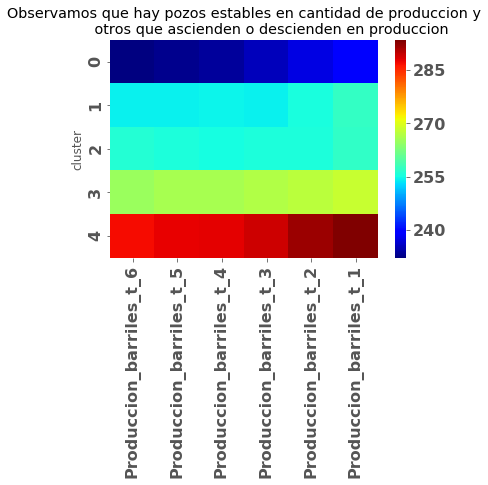

In [108]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

In [109]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t','dummi_pico_bajo',
                                                    'cluster']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'sum_produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4']

In [110]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_barriles_t')

# Conjunto de validacion

In [111]:
# y_valid.index.tolist()

# seguimos entrenando

In [112]:
x_train.shape

(5945, 146)

In [113]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 10000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
[10000]	valid_0's l1: 10.8416
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 10.8416


In [114]:
clf.num_trees()

10000

# Evaluacion

In [115]:
y_pred = clf.predict(x_valid)

In [116]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [118]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.9170
R^2 ajustada$: 0.8991
MEA: 11.3348
MSE 1175.5877
RMSE 34.2868


In [119]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

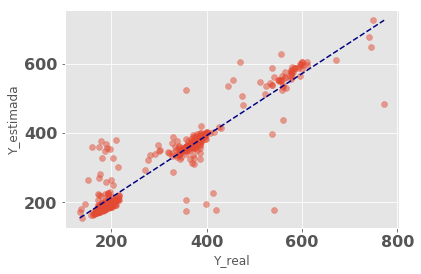

In [122]:
yy_plot(y_valid, y_pred)

## Residuos

In [123]:
res = (y_valid - y_pred) / y_valid

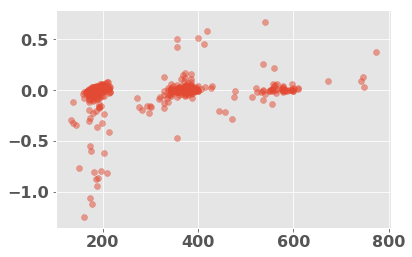

In [124]:
plt.scatter(y_valid, res, alpha=0.5)

In [125]:
res.median() * 100

-0.06786247917282881

In [126]:
res.mean() * 100

-1.6193354091784775

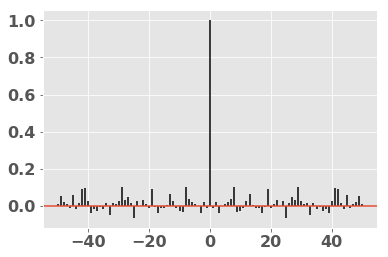

In [127]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

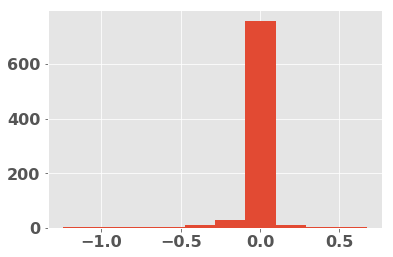

In [128]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

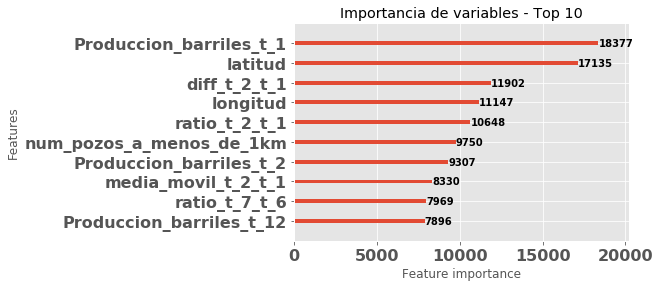

In [129]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [130]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [131]:
shap.force_plot(explainer.expected_value, shap_values[2,:], x_valid.iloc[2,:])

## Efectos Marginales

In [132]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [133]:
a.tail(8).index

Index(['media_movil_t_2_t_1', 'Produccion_barriles_t_2',
       'num_pozos_a_menos_de_1km', 'ratio_t_2_t_1', 'longitud', 'diff_t_2_t_1',
       'latitud', 'Produccion_barriles_t_1'],
      dtype='object')

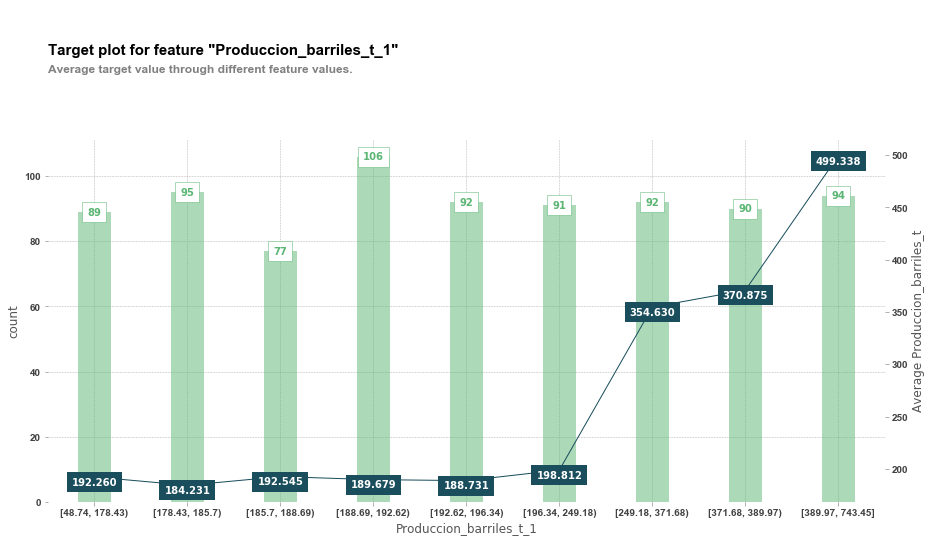

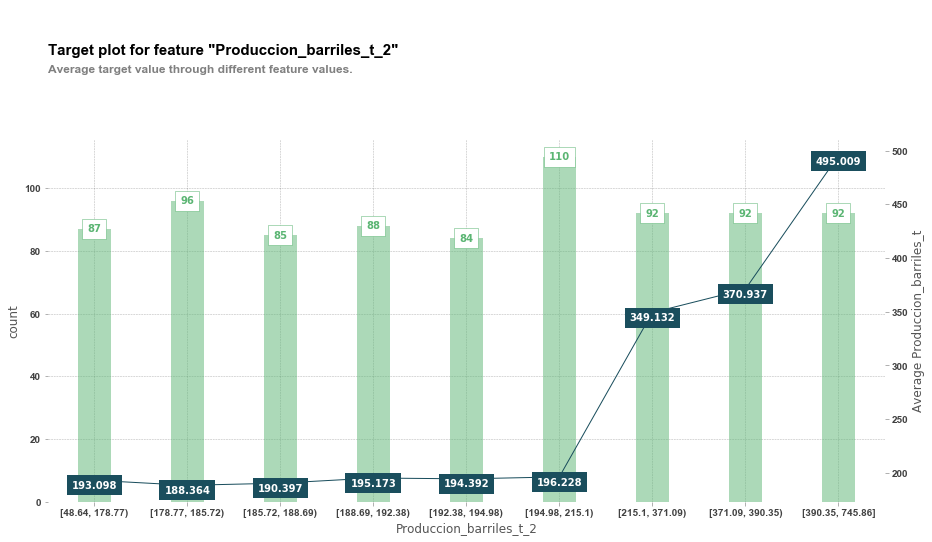

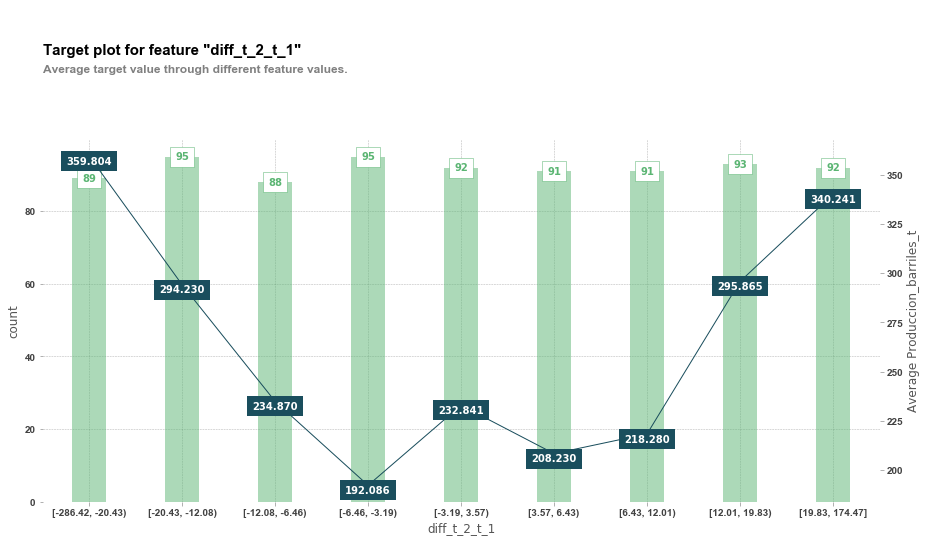

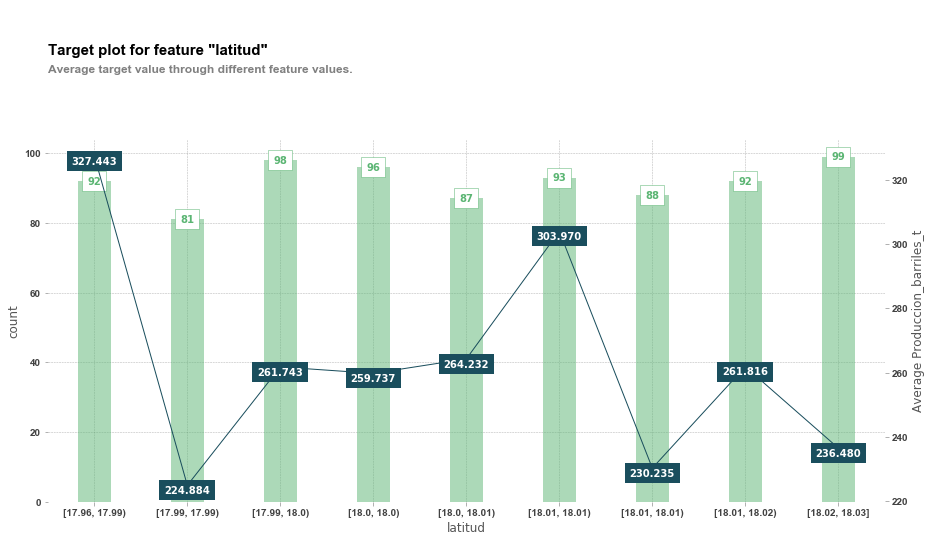

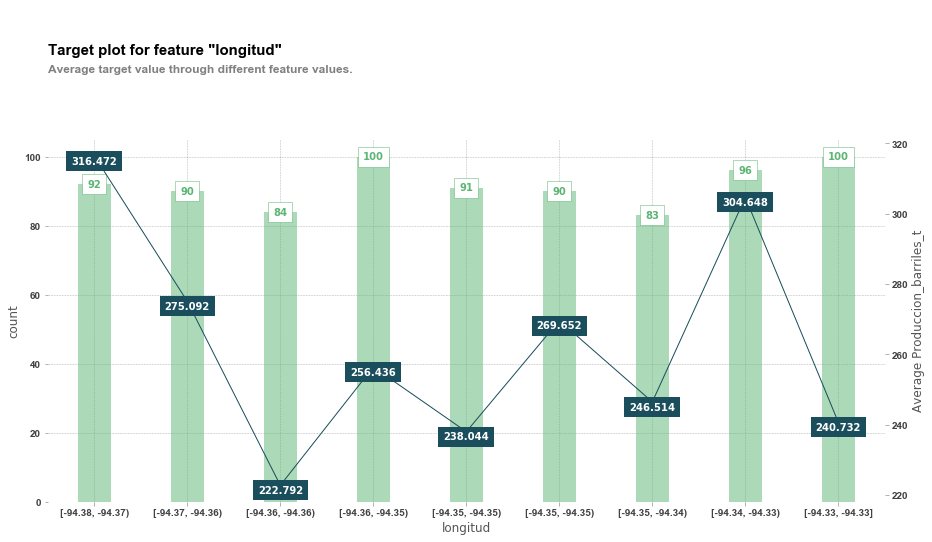

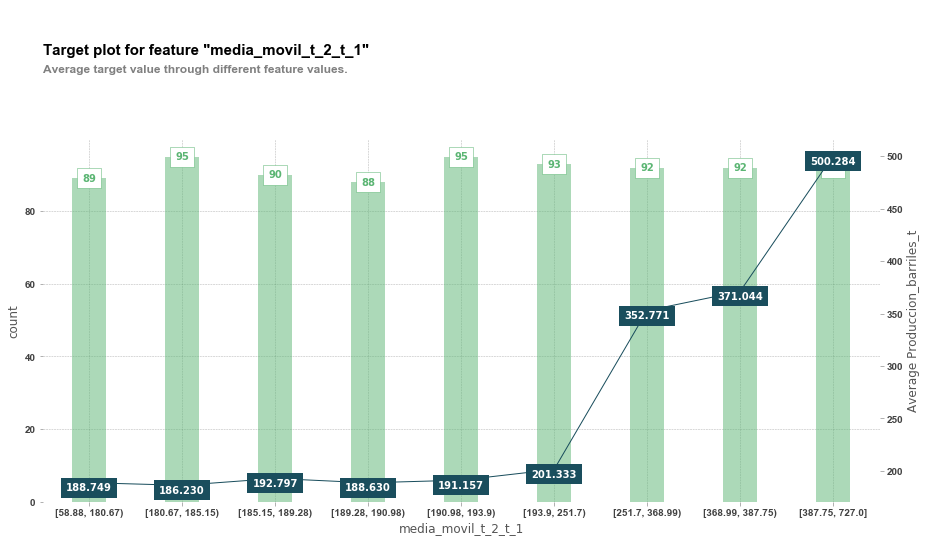

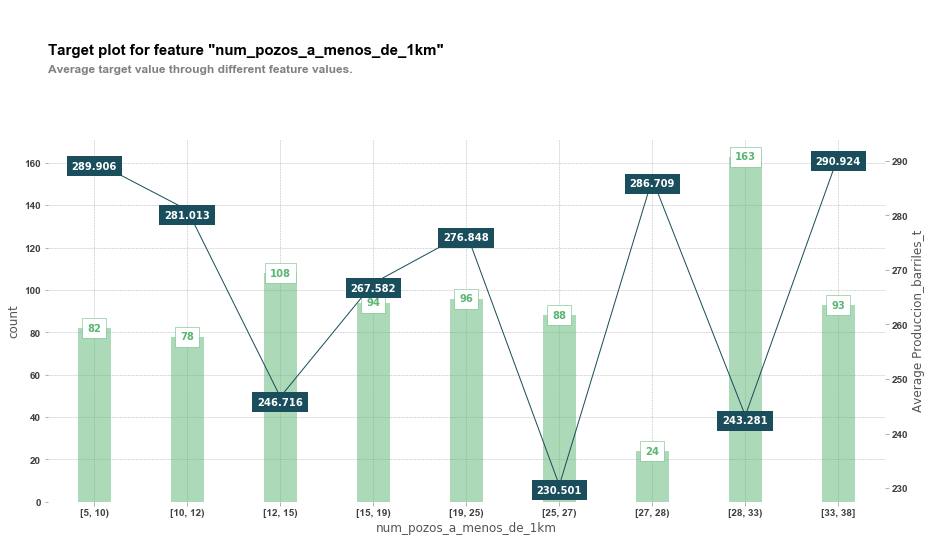

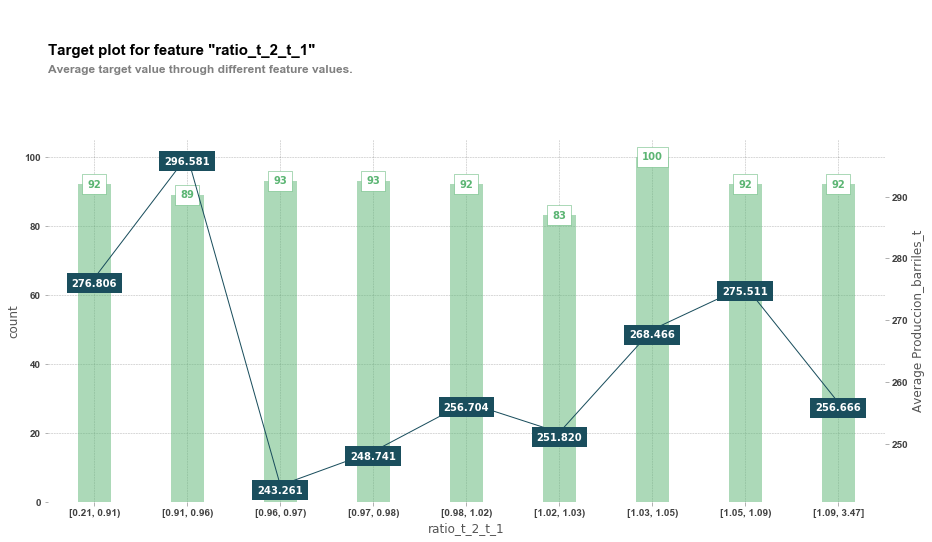

In [134]:
for col in sorted(a.tail(8).index):
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_barriles_t'
    )

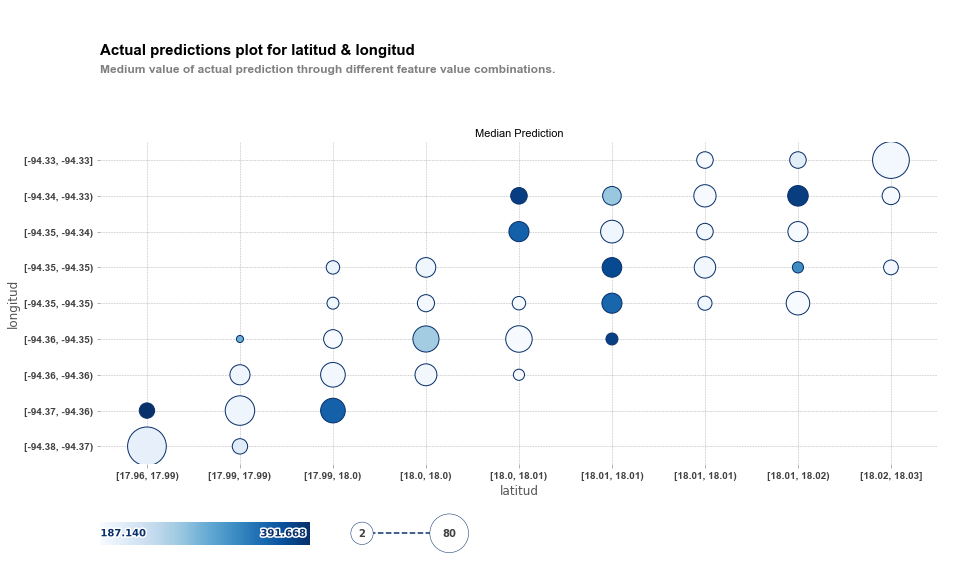

In [135]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=clf, X=pd.concat([x_valid,y_valid],1),
    features=['latitud', 'longitud'],
    feature_names=['latitud', 'longitud'])

In [ ]:
pdp_67_24_rf = pdp.pdp_interact(model=clf,
                                dataset=pd.concat([x_valid,y_valid],1),
                                model_features=num_cols,
                                features=['latitud', 'longitud'],
                                num_grid_points=[10, 10],
                                percentile_ranges=[(5, 95), (5, 95)],
                                n_jobs=7)

In [ ]:
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_67_24_rf,
                                  feature_names=['latitud', 'longitud'],
                                  plot_type='contour',
                                  x_quantile=True,
                                  plot_pdp=True)

## Pendiente interpretar los de shap

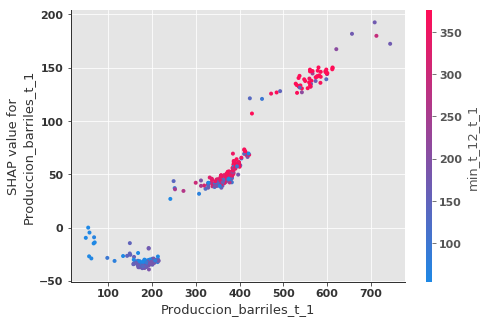

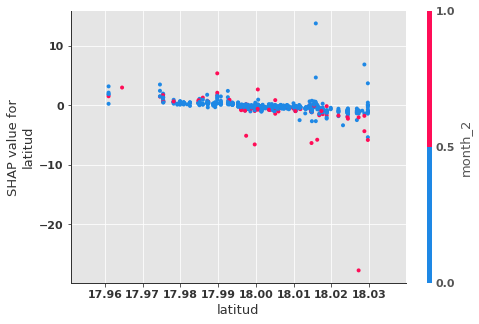

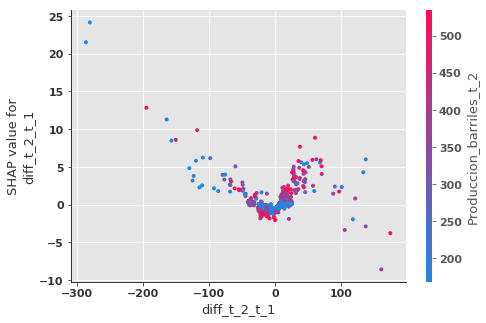

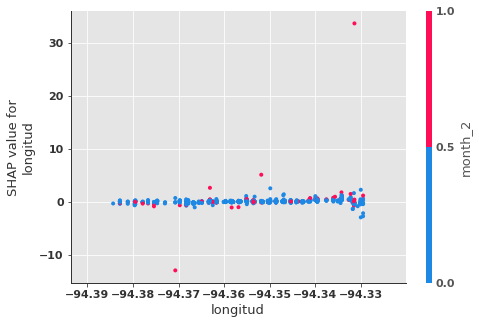

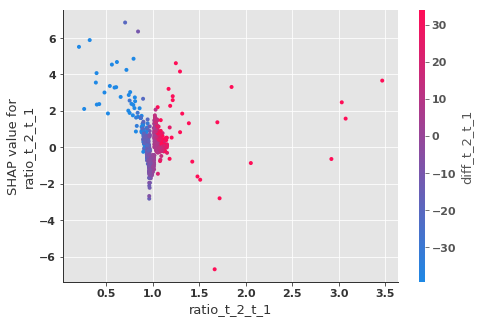

In [137]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

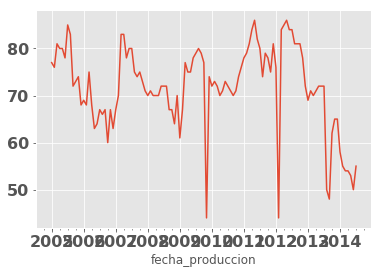

In [138]:
df_train.groupby('fecha_produccion').count()['Pozo'].plot()

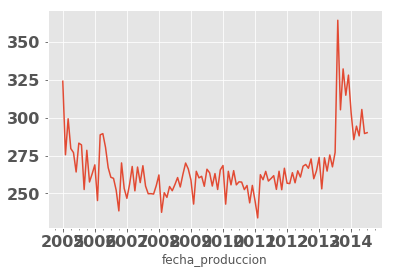

In [139]:
df_train.groupby('fecha_produccion')['Produccion_barriles_t'].mean().plot()

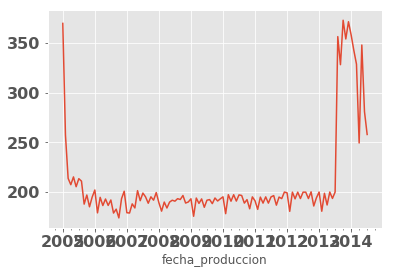

In [140]:
df_train.groupby('fecha_produccion')['Produccion_barriles_t'].median().plot()
# .sort_values(ascending=False)

# Guardado de mejor modelo

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'light_gbm_oil_02-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

In [ ]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [141]:
idx = df_train.Pozo.sample(10)

In [142]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [143]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [144]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [145]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

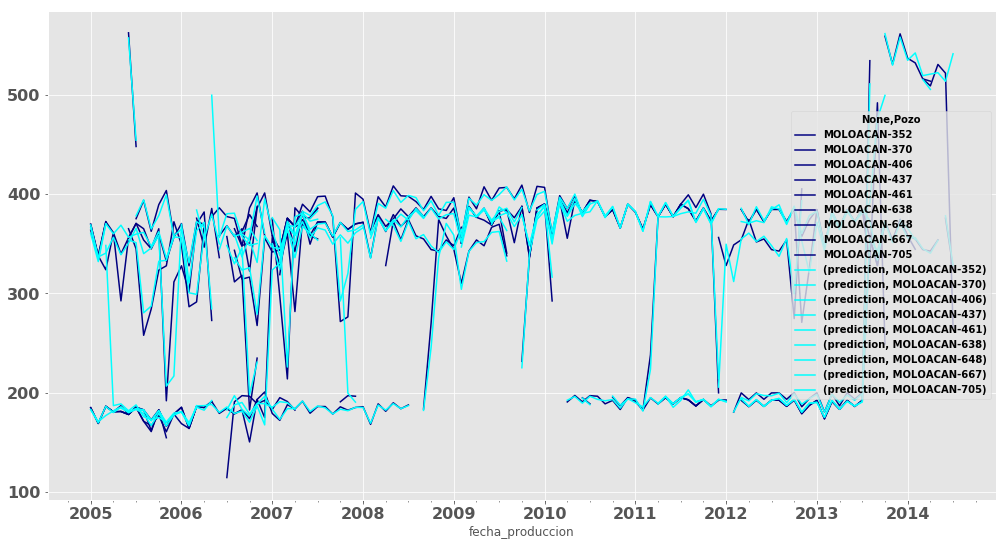

In [146]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [147]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [148]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [149]:
df_train['prediction_oil'] = preds

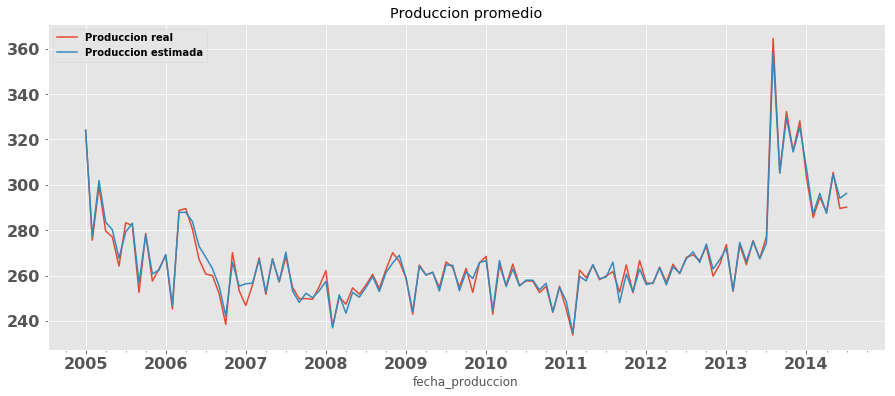

In [150]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction_oil']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [151]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

74.0

In [152]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [163]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [167]:
df_vivos[['Produccion_barriles_t','prediction_oil']].head()

,Produccion_barriles_t,prediction_oil
56,379.34,389.028930
57,356.68,362.169347
58,427.27,407.675551
59,398.20,414.202477
60,430.20,413.944241


In [169]:
df_vivos.fecha_produccion.min()

Timestamp('2005-01-01 00:00:00')

In [154]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [170]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2005-01-01'].index

In [171]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [173]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction_oil']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_oil'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_oil'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_barriles_t - df_vivos2.prediction_oil

In [ ]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [ ]:
# df_vivos2.to_csv("perfiles_pozo.csv")

# Forecasting

In [159]:
def forecast_pozos(df_pozos, num_cols, algoritmo, inicio = 0, fin = 5):
    """Realiza forecasting para una lista de pozos.
    
    Parametros:
    df_pozos -- Lista de pozos para realizar forecasting
    num_cols -- Variables a utilizar en el algoritmo
    algoritmo - Algoritmo a utilizar (p.ej., clf)
    
    Return:
    df_pred -- DataFrame con las predicciones de cada pozo
    
    Variables:
    pozos -- Cantidad de pozos en la lsita
    
    Funciones auxiliares:
    gen_cols(df) -. Calcula las variables
    forecast(df, n_pred , num_cols, algoritmo, columna_inicial = 2, lag =7) - Realiza el forecast
    """
    if fin == 'all':
        fin = df_pozos.shape[0]
        
    def gen_cols(df):
        """Calculo de variables
        """
    
        df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
        df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
        df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
        df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
        df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
        df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
        df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
        df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
        df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
        df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

        # cambio en la produccion
        df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
        df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
        df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
        df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
        df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


        df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
        df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
        
        
        df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
        df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
        df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
        df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
        df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
        df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
        df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
        df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
        df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
        df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

        # cambio en la produccion
        df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
        df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
        df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
        df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
        df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1
        
        
        df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
        df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
        df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
        df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
        df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
        df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
        df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
        df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
        df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
        df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
        df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
        df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                                'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

        df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
        df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
        df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
        df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
        df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
        df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
        df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
        df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
        df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
        df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
        df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
        df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                                'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)
        # desviacion estandar
        df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
        # mediana
        df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                   'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
        # minimo
        df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
        #quantiles
        df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
        df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
        df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
        df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
        #maximo
        df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

        #rango
        df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

        # medias moviles
        df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                        'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        
        df['produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)
        
        df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
        df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

        return df
    
    def forecast(df, n_pred , num_cols, algoritmo, columna_inicial = 2, lag = 7):
        """Realiza forecasting
        
        Parámetros:
        df -- DataFrame para realizar el forecasting
        n_pred -- Numero de predicciones a realizar
        num_cols -- Variables a utilizar en el algoritmo
        algoritmo - Algoritmo a utilizar (p.ej., clf)
        columna_inicial -- index de la ultima columna en el tiempo (p.ej, t-6)
        lag -- Numero de periodos
        
        Return:
        df -- DataFrame original con las proyecciones
        valor_pred -- Array con los valores de cada prediccion
        
        """
        valor_pred = []
        for i in range(n_pred):
            # prediccion de la ultima fila
            valor = algoritmo.predict(df[num_cols][-1:])
            # genera una nueva fila
            df = pd.concat([df,df.iloc[-1:]], ignore_index=True)
            for j in range(lag-1):
                # recorrer valores
                df.iloc[-1, j + columna_inicial] = df.iloc[-1, j +1 + columna_inicial]

            # colocar el valor de la prediccion
            df.iloc[-1, columna_inicial + lag - 1] = valor
            # calcular las variables que dependen en el tiempo
            gen_cols(df)
            valor_pred.append(valor)
        return df, valor_pred

    df_pred = pd.DataFrame()

    pozos = df_pozos.Pozo.unique()[inicio : fin]
    
    for i in range(pozos.shape[0]):
        # selecciona un pozo de la lista de pozos
        df_prueba = df_pozos[df_pozos.Pozo == pozos[i]].reset_index(drop=True)

        # toma los primeros 6 meses
        df_simul = df_prueba.iloc[0:6]
        n_pred = df_prueba.shape[0] - 6
        
        # forecast
        df_simul, valor_pred = forecast(df_simul, n_pred, num_cols, algoritmo, lag=12)

        # guarda la misma fecha
        df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
        
        #guarda los resultados en un dataframe
        df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
    return df_pred

In [179]:
df_forcastiiing = forecast_pozos(df_vivos,num_cols, clf,fin='all')

In [181]:
df_forcastiiing.groupby(['Pozo','fecha_produccion']).

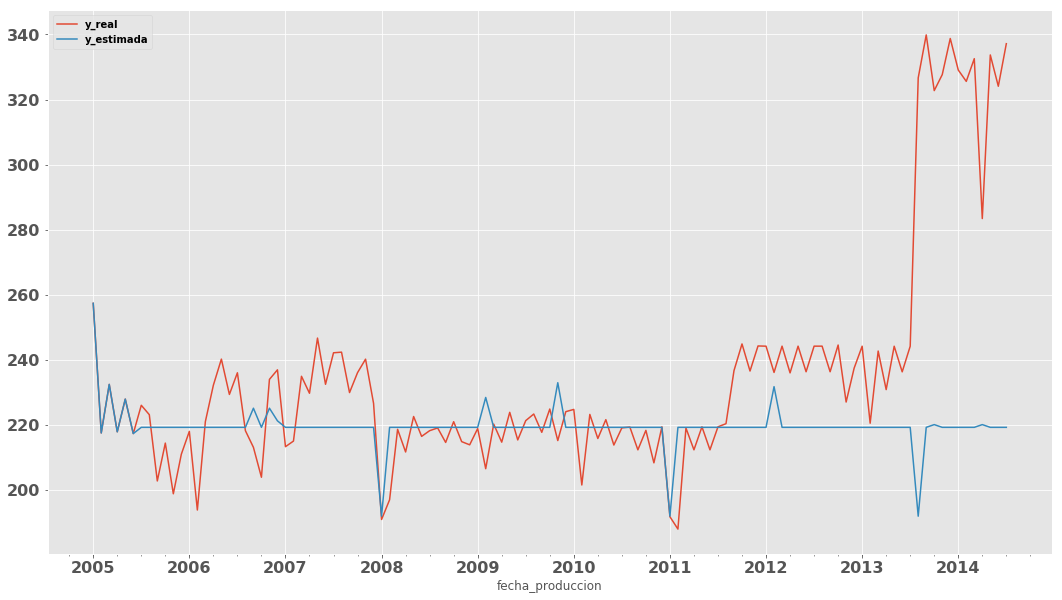

In [182]:
a = df_vivos[['Pozo','fecha_produccion','Produccion_barriles_t']]
a.columns = ['Pozo','fecha_produccion','y_real']
b = df_forcastiiing[['Pozo','fecha_produccion','Produccion_barriles_t']]
b.columns = ['Pozo','fecha_produccion','y_estimada']
c = a.merge(b,on=['Pozo','fecha_produccion'])
c.groupby('fecha_produccion')[['y_real','y_estimada']].mean().plot(figsize=(18,10))

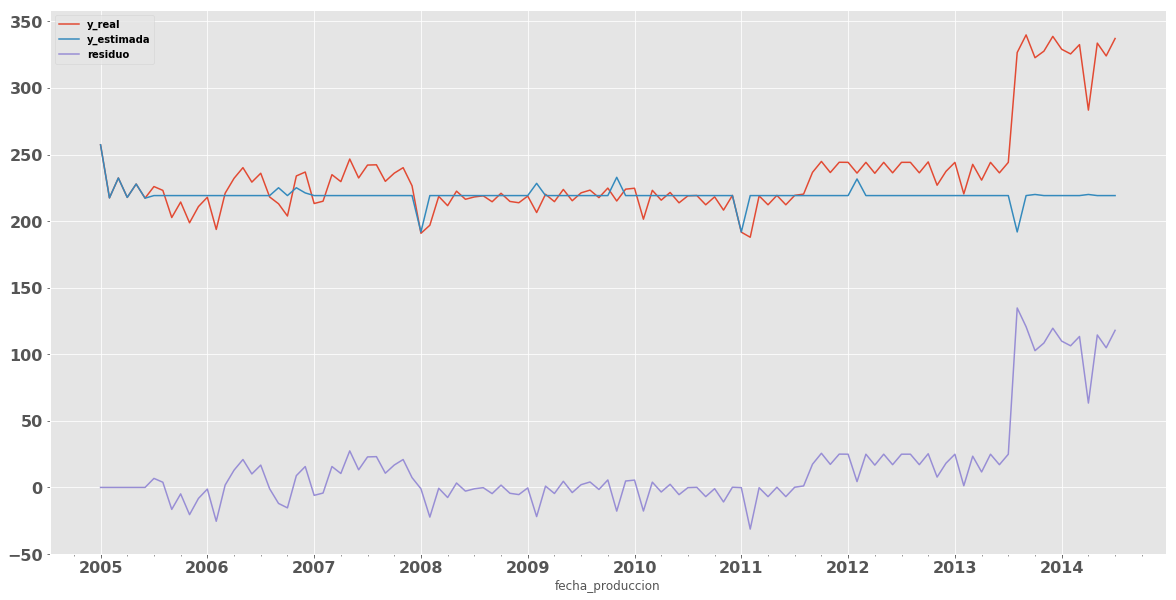

In [194]:
c.plot(figsize=(20,10))

In [207]:
c = a.merge(b,on=['Pozo','fecha_produccion'])
c = c.groupby('fecha_produccion')[['y_real','y_estimada']].mean()
c['residuo'] = c.y_real - c.y_estimada
c.iplot()

In [204]:
a.Pozo.unique()

array(['MOLOACAN-112', 'MOLOACAN-319', 'MOLOACAN-339', 'MOLOACAN-340',
       'MOLOACAN-4', 'MOLOACAN-414', 'MOLOACAN-511', 'MOLOACAN-625'],
      dtype=object)

In [ ]:
c = a.merge(b,on=['Pozo','fecha_produccion'])
c = c.groupby('fecha_produccion')[['y_real','y_estimada']].mean()
c['residuo'] = c.y_real - c.y_estimada
c.iplot()

In [199]:
c = a.merge(b,on=['Pozo','fecha_produccion'])

In [206]:
C = c[c.Pozo =='MOLOACAN-319'].groupby('fecha_produccion')[['y_real','y_estimada']].mean()
C['residuo'] = C.y_real - C.y_estimada
C.iplot()

# Modelo de Gas

# Entrenamiento

In [161]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','prediction','prediction_oil','prediction_gas']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster']

In [162]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_gasMMpc_t')

# Conjunto de validacion

In [163]:
y_valid.index.tolist()

[9606,
 832,
 9019,
 3469,
 9679,
 7883,
 9708,
 998,
 10691,
 8758,
 1289,
 3182,
 4207,
 1996,
 623,
 1719,
 193,
 9557,
 2220,
 7843,
 10322,
 4218,
 4881,
 8573,
 9234,
 6103,
 3813,
 7973,
 9257,
 2600,
 5815,
 5651,
 7488,
 7769,
 8669,
 4497,
 8689,
 4011,
 4068,
 5549,
 4955,
 8009,
 10955,
 7764,
 116,
 7530,
 6258,
 5316,
 801,
 740,
 7786,
 3631,
 2582,
 9409,
 2712,
 6231,
 9696,
 2034,
 6953,
 10891,
 6887,
 5423,
 10778,
 3773,
 5011,
 1665,
 10430,
 3700,
 6808,
 8989,
 1111,
 3504,
 5266,
 1799,
 9622,
 1384,
 7991,
 4133,
 4185,
 5943,
 2957,
 2614,
 9356,
 9101,
 7961,
 10747,
 9643,
 7293,
 10207,
 3393,
 9958,
 7102,
 2343,
 10931,
 3905,
 1274,
 7462,
 6465,
 2809,
 5756,
 14,
 10366,
 8393,
 1374,
 1226,
 7075,
 6904,
 877,
 3345,
 2335,
 2762,
 1889,
 9978,
 925,
 867,
 388,
 10895,
 8553,
 8256,
 7988,
 246,
 5154,
 895,
 9353,
 9637,
 3464,
 10759,
 7001,
 10788,
 6094,
 1792,
 3567,
 1810,
 7192,
 8103,
 9185,
 10372,
 1139,
 10477,
 8624,
 3144,
 5954,
 2937,
 10924,
 3425,
 3016,
 10211,
 5003,
 5277,
 9785,
 1958,
 2140,
 1982,
 4962,
 7890,
 5457,
 9168,
 9402,
 544,
 2005,
 5214,
 531,
 8911,
 932,
 6164,
 6007,
 547,
 3862,
 3284,
 3937,
 1749,
 3992,
 1174,
 5523,
 3678,
 163,
 9927,
 6899,
 2068,
 9245,
 9991,
 10684,
 9515,
 5786,
 10018,
 2882,
 3549,
 3143,
 6338,
 9405,
 5546,
 91,
 734,
 2083,
 6067,
 1470,
 3480,
 5770,
 10830,
 6285,
 37,
 10155,
 10762,
 9984,
 6996,
 7698,
 10249,
 538,
 345,
 8389,
 2006,
 2159,
 2896,
 6960,
 6331,
 3124,
 8136,
 10108,
 2872,
 5317,
 7109,
 9769,
 4117,
 9998,
 2208,
 8988,
 2203,
 3397,
 10454,
 8084,
 2390,
 6588,
 3742,
 3212,
 319,
 2636,
 5468,
 6921,
 4159,
 6364,
 8175,
 7836,
 3498,
 2503,
 1434,
 7271,
 7697,
 5061,
 87,
 2685,
 3637,
 8425,
 619,
 8576,
 9451,
 8490,
 2589,
 8649,
 1031,
 10027,
 2042,
 5595,
 8237,
 4582,
 1159,
 9818,
 7685,
 8195,
 6306,
 5553,
 2317,
 4890,
 3680,
 9048,
 1165,
 5062,
 2293,
 6278,
 5721,
 4163,
 9304,
 95,
 5074,
 10110,
 4345,
 7134,
 7956,
 160,
 5359,
 7785,
 7025,
 2901,
 9290,
 2219,
 99,
 10319,
 10368,
 835,
 4900,
 5064,
 6795,
 4249,
 10280,
 1865,
 4996,
 4607,
 8320,
 6043,
 6216,
 4350,
 6610,
 1716,
 4805,
 10051,
 6665,
 5029,
 3281,
 4554,
 8143,
 3562,
 3261,
 4549,
 5040,
 7573,
 9384,
 4903,
 6324,
 1169,
 5171,
 3632,
 7761,
 10571,
 2911,
 6818,
 10914,
 10221,
 10456,
 9746,
 4995,
 9948,
 6609,
 2788,
 9504,
 8778,
 10267,
 3651,
 5230,
 9526,
 4907,
 3407,
 5329,
 5100,
 5615,
 5297,
 3803,
 6496,
 4055,
 9366,
 4958,
 1269,
 8417,
 7645,
 5519,
 6362,
 3739,
 8102,
 9147,
 5293,
 1296,
 7989,
 6561,
 5632,
 55,
 9633,
 2512,
 4799,
 1572,
 1530,
 629,
 10429,
 7644,
 9636,
 2747,
 3448,
 1196,
 3308,
 4132,
 5859,
 7590,
 9142,
 3170,
 3121,
 6441,
 1097,
 2552,
 5825,
 5823,
 5655,
 5289,
 7356,
 8540,
 6019,
 4863,
 10406,
 154,
 9646,
 7526,
 5384,
 4436,
 8145,
 7142,
 1674,
 62,
 10030,
 5098,
 2750,
 4199,
 4227,
 9032,
 5465,
 7875,
 5968,
 1413,
 10139,
 7832,
 5556,
 5429,
 6063,
 10897,
 6225,
 752,
 3028,
 7440,
 2629,
 5646,
 5299,
 8739,
 8236,
 1155,
 3468,
 10756,
 10095,
 6667,
 1002,
 837,
 4904,
 7808,
 8123,
 1061,
 882,
 5089,
 3933,
 1963,
 953,
 7559,
 6578,
 10389,
 4992,
 2123,
 10545,
 7358,
 2107,
 6234,
 5960,
 2707,
 10411,
 1259,
 10448,
 5392,
 2858,
 285,
 3186,
 8182,
 506,
 442,
 2097,
 2922,
 529,
 6971,
 4977,
 1125,
 4801,
 3952,
 7791,
 2639,
 2942,
 7442,
 10421,
 3300,
 4892,
 2085,
 9493,
 8785,
 7797,
 4155,
 2817,
 2112,
 5828,
 346,
 3415,
 149,
 3088,
 8640,
 3781,
 5362,
 1432,
 748,
 3607,
 2772,
 831,
 10172,
 7375,
 8205,
 3677,
 6348,
 1819,
 7548,
 6405,
 7094,
 1404,
 2277,
 7119,
 54,
 5436,
 2453,
 9391,
 1473,
 5945,
 3763,
 23,
 9487,
 10855,
 10283,
 2260,
 10374,
 174,
 7706,
 795,
 4797,
 6839,
 9362,
 1359,
 10583,
 3010,
 8598,
 1166,
 1468,
 2153,
 6188,
 7655,
 4366,
 2703,
 8763,
 3717,
 5239,
 6697,
 6168,
 443,
 10605,
 9066,
 212,
 9510,
 7716,
 3833,
 5421,
 3346,
 8071,
 3470,
 2398,
 1283,
 9486,
 9763,
 2793

# seguimos entrenando

In [164]:
x_train.shape

(7892, 144)

In [165]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
[10000]	valid_0's l1: 0.0107609
Early stopping, best iteration is:
[12820]	valid_0's l1: 0.0107478


In [166]:
clf.num_trees()

12820

# Evaluacion

In [167]:
y_pred = clf.predict(x_valid)

In [168]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [169]:
y_valid.mean()

0.15417502278942577

In [170]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.7324
R^2 ajustada$: 0.6920
MEA: 0.0115
MSE 0.0020
RMSE 0.0453


In [171]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

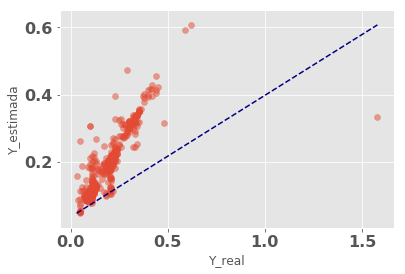

In [172]:
yy_plot(y_valid, y_pred)

## Residuos

In [173]:
res = (y_valid - y_pred) / y_valid

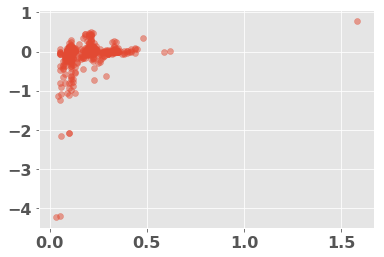

In [174]:
plt.scatter(y_valid, res, alpha=0.5)

In [175]:
res.median() * 100

0.015693427924401426

In [176]:
res.mean() * 100

-3.5071195563585276

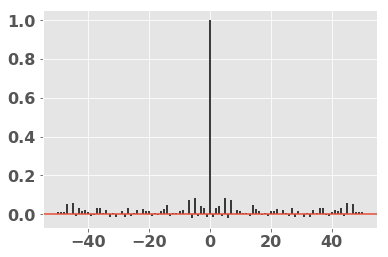

In [177]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

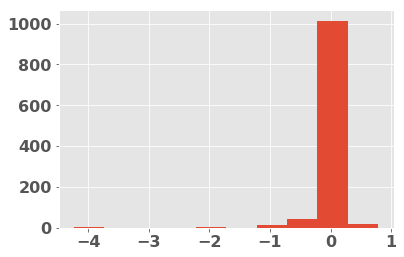

In [178]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

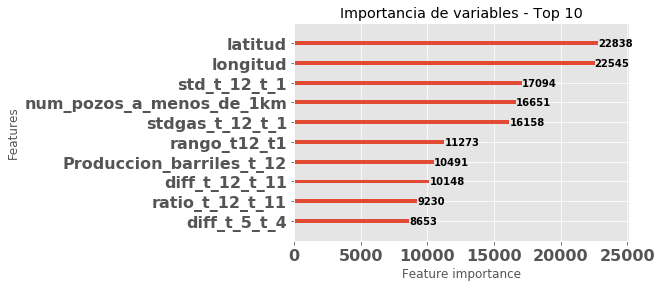

In [179]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [180]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [181]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [182]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [183]:
a.tail(8).index

Index(['diff_t_12_t_11', 'Produccion_barriles_t_12', 'rango_t12_t1',
       'stdgas_t_12_t_1', 'num_pozos_a_menos_de_1km', 'std_t_12_t_1',
       'longitud', 'latitud'],
      dtype='object')

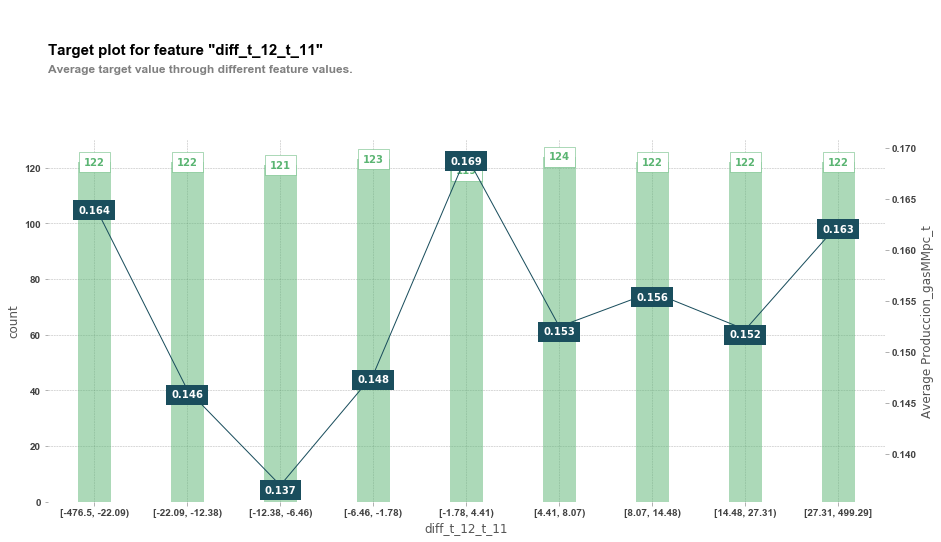

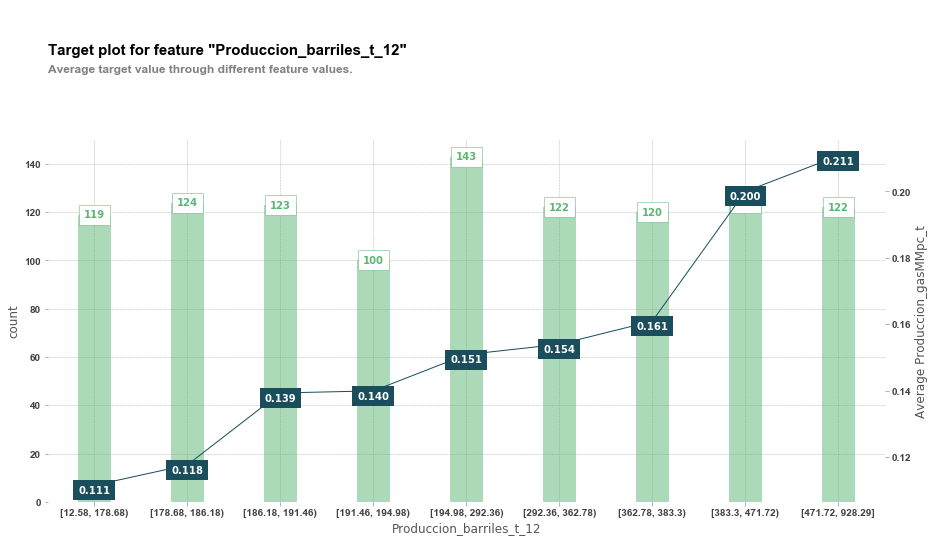

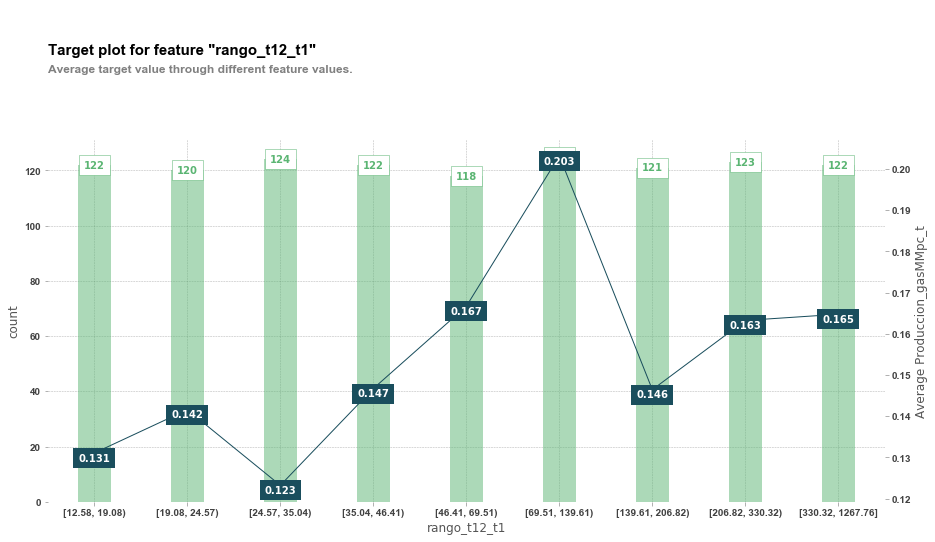

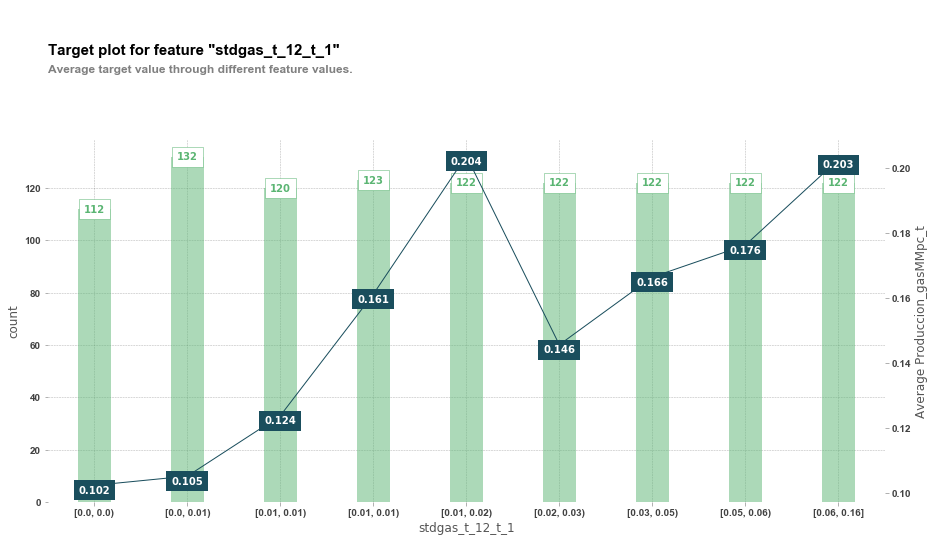

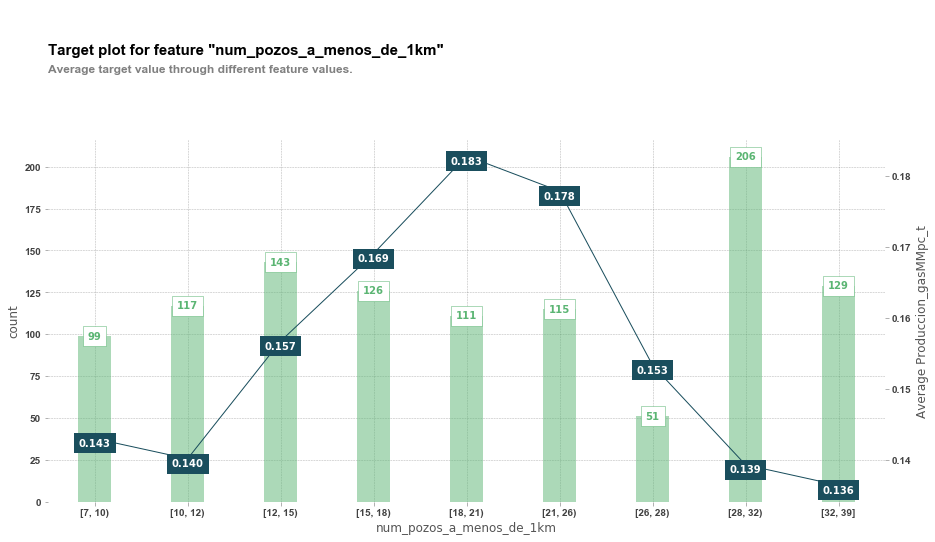

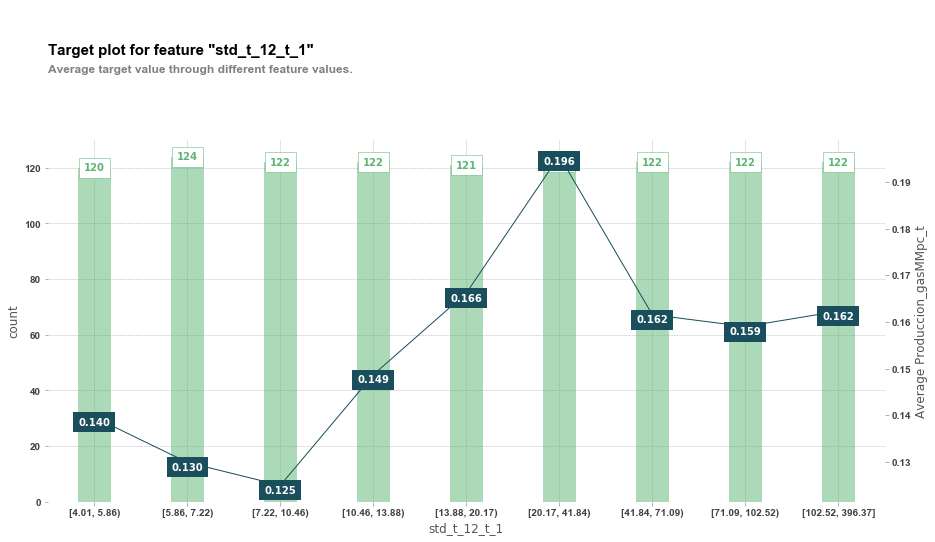

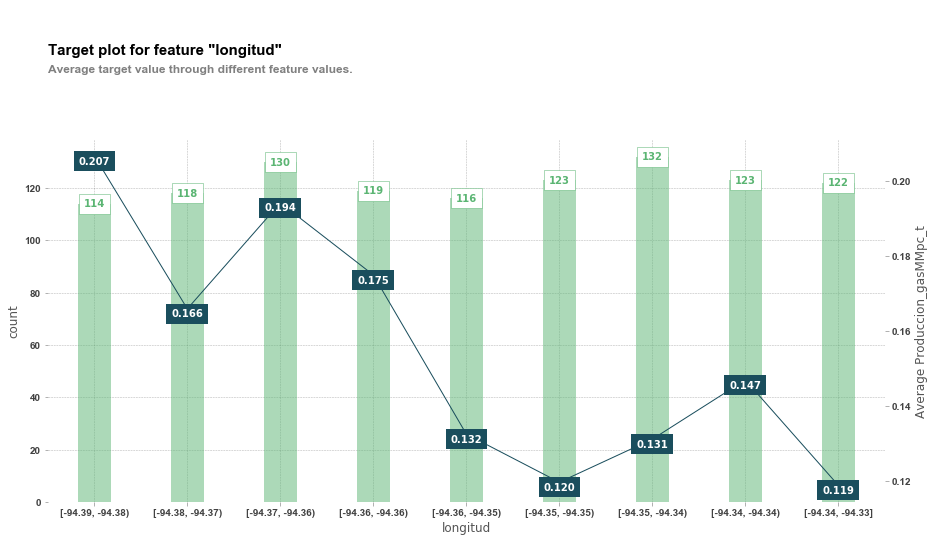

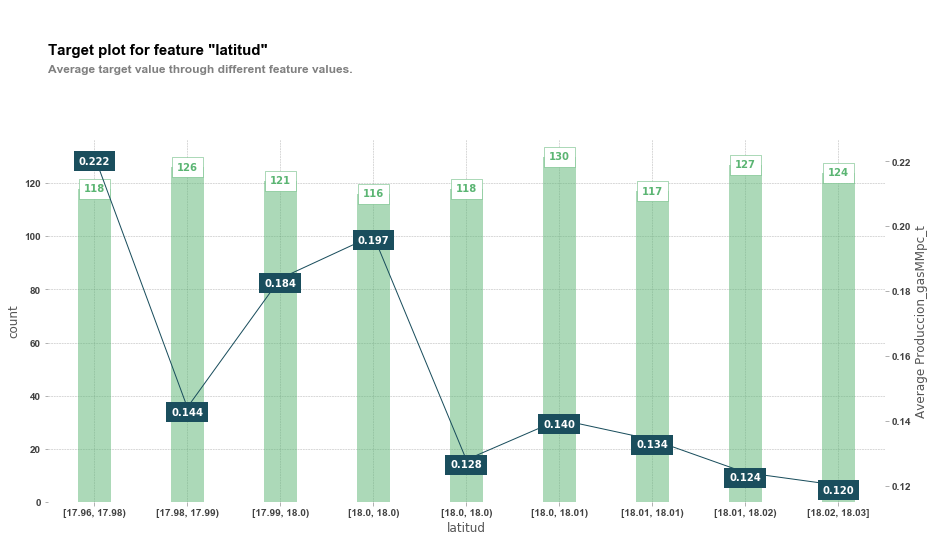

In [184]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_gasMMpc_t'
    )

## Pendiente interpretar los de shap

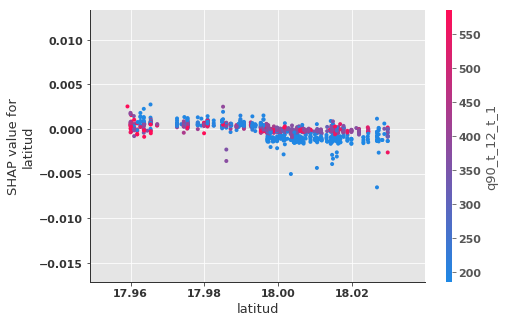

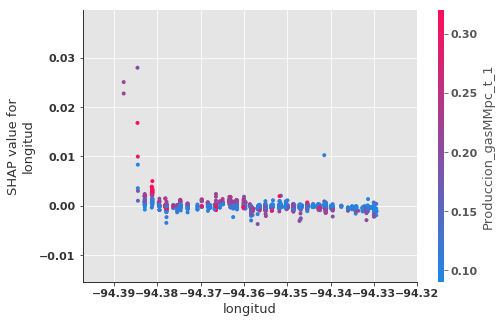

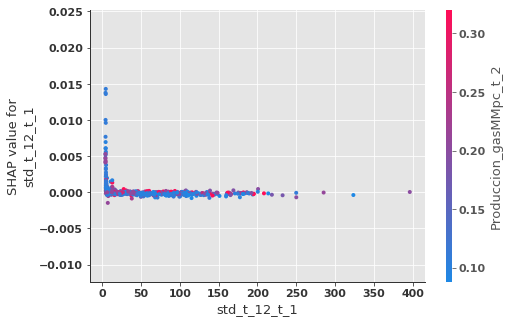

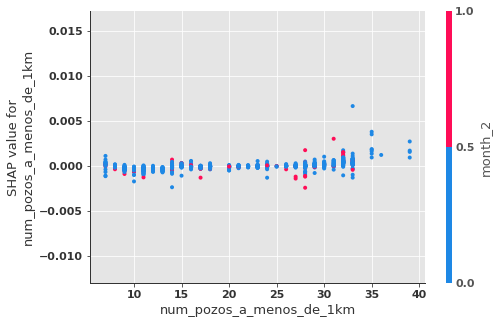

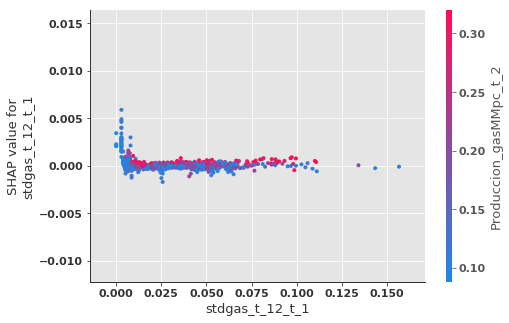

In [185]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [186]:
joblib.dump(clf, 'light_gbm_gas_01-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

['light_gbm_gas_01-08-2019.pkl']

In [187]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [188]:
idx = df_train.Pozo.sample(10)

In [189]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().index

In [190]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_gasMMpc_t.first().unstack(0)

In [191]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [192]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

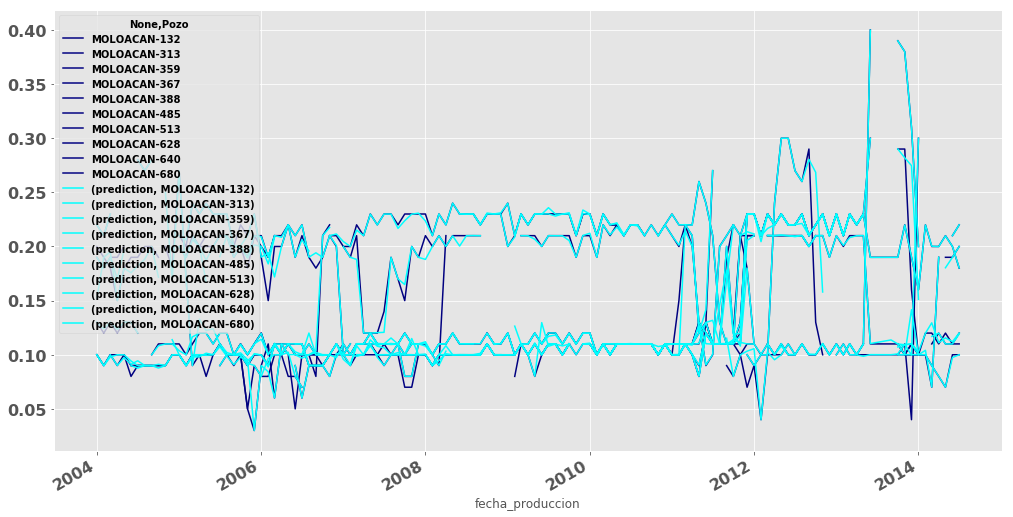

In [193]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [194]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [195]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_gasMMpc_t

In [196]:
df_train['prediction_gas'] = preds

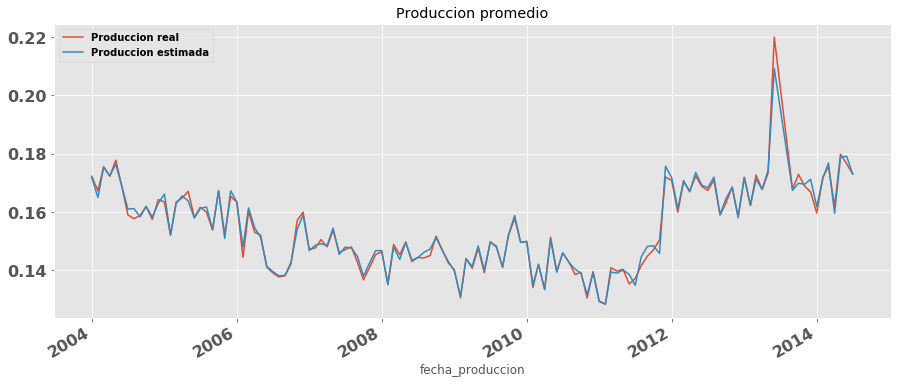

In [197]:
df_train.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [198]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

84.5

In [199]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [200]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [201]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [202]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [203]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [204]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [205]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_gasMMpc_t - df_vivos2.prediction_gas

In [206]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [207]:
df_vivos2.to_csv("perfiles_pozo_gas.csv")